<a href="https://colab.research.google.com/github/urosdedic/predikcija-kategorije-proizvoda/blob/main/predikcija_kategorije_proizvoda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predikcija kategorije proizvoda prema naslovu

## Istraživačka analiza podataka (EDA - exploratory data analysis)

In [48]:
import pandas as pd

# load dataset from GitHub
url = "https://raw.githubusercontent.com/urosdedic/predikcija-kategorije-proizvoda/main/data/products.csv"

df = pd.read_csv(url)

# Print shape (number of rows and columns)
print("Dataset shape (rows, columns):", df.shape)

# Show first 5 rows
print("\nFirst 5 rows:")
display(df.head())

# Show column data types and non-null counts
print("\nDataset info:")
df.info()

# Count missing values per column
print("Missing values per column:")
print(df.isna().sum())

# Count occurrences of each category label
category_counts = df['Category Label'].value_counts()

# Print counts
print("Category distribution (counts):")
print(category_counts)

Dataset shape (rows, columns): (35311, 8)

First 5 rows:


,product ID,Product Title,Merchant ID,Category Label,Product Code,Number_of_Views,Merchant Rating,Listing Date
0,1,apple iphone 8 plus 64gb silver,1,Mobile Phones,QA-2276-XC,860.0,2.5,5/10/2024
1,2,apple iphone 8 plus 64 gb spacegrau,2,Mobile Phones,KA-2501-QO,3772.0,4.8,12/31/2024
2,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,Mobile Phones,FP-8086-IE,3092.0,3.9,11/10/2024
3,4,apple iphone 8 plus 64gb space grey,4,Mobile Phones,YI-0086-US,466.0,3.4,5/2/2022
4,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,Mobile Phones,NZ-3586-WP,4426.0,1.6,4/12/2023



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35311 entries, 0 to 35310
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product ID       35311 non-null  int64  
 1   Product Title    35139 non-null  object 
 2   Merchant ID      35311 non-null  int64  
 3   Category Label   35267 non-null  object 
 4   Product Code     35216 non-null  object 
 5   Number_of_Views  35297 non-null  float64
 6   Merchant Rating  35141 non-null  float64
 7    Listing Date    35252 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 2.2+ MB
Missing values per column:
product ID           0
Product Title      172
Merchant ID          0
Category Label      44
Product Code        95
Number_of_Views     14
Merchant Rating    170
 Listing Date       59
dtype: int64
Category distribution (counts):
Category Label
Fridge Freezers     5495
Washing Machines    4036
Mobile Phones       4020
CPUs     

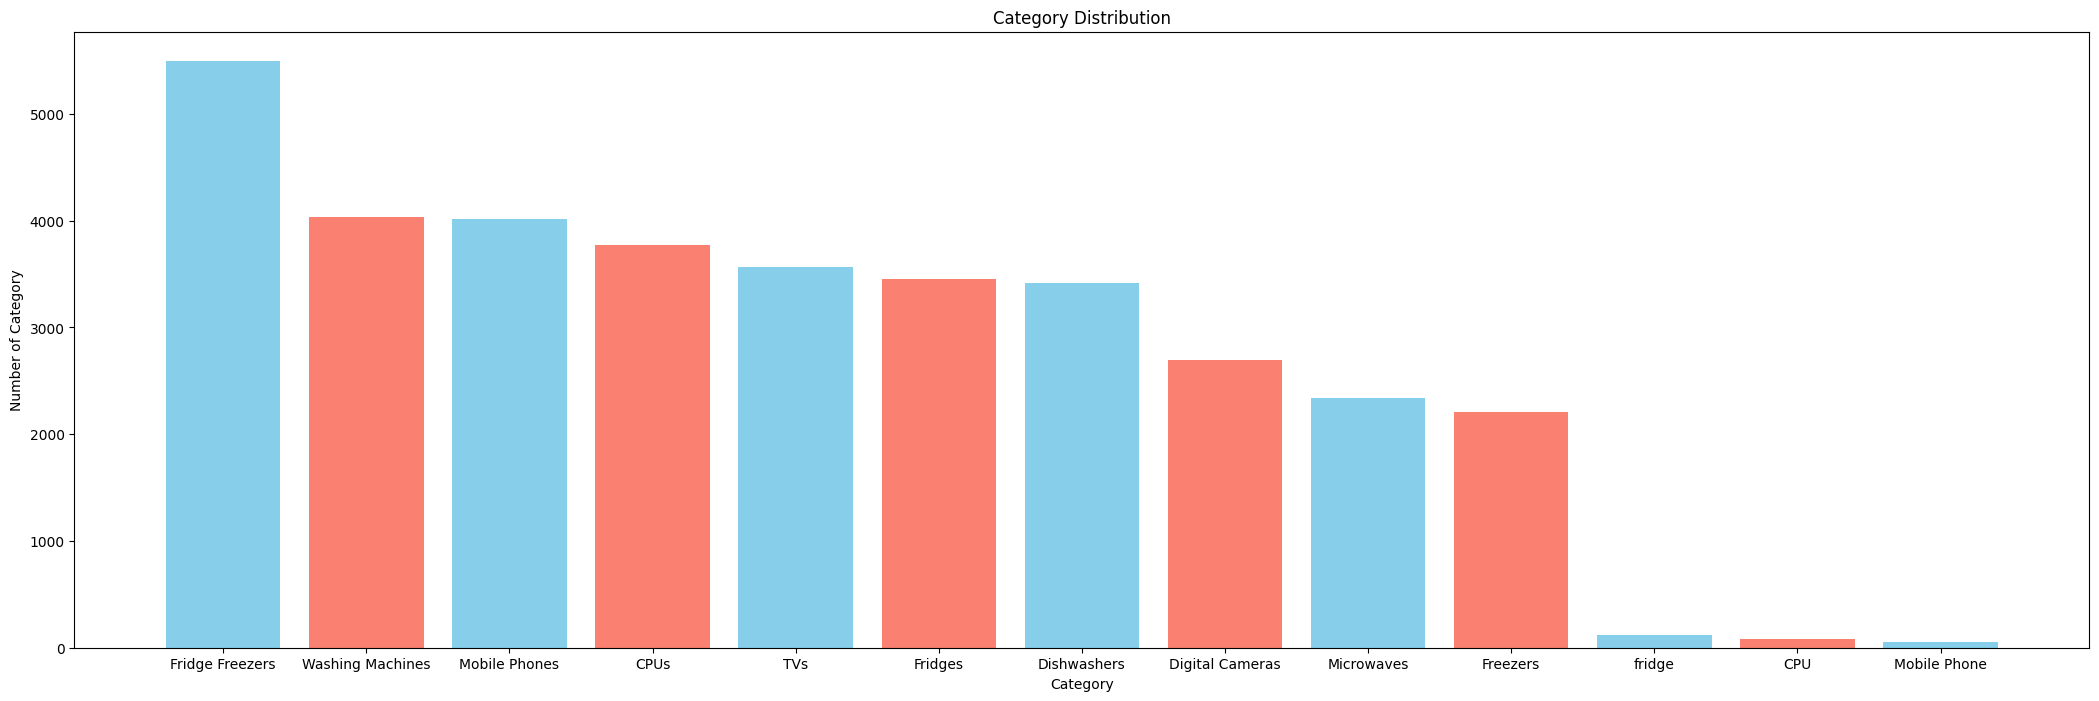

In [49]:
# Plot category distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(26, 8))
plt.bar(category_counts.index, category_counts.values, color=['skyblue', 'salmon'])
plt.title("Category Distribution")
plt.xlabel("Category")
plt.ylabel("Number of Category")
plt.show()

## Čišćenje i pretprocesiranje podataka

In [50]:
# Drop all rows with missing values
df = df.dropna()

# Display new shape of the dataset
print("New dataset shape:", df.shape)

# Count missing values per column
print("Missing values per column:")
print(df.isna().sum())


New dataset shape: (34760, 8)
Missing values per column:
product ID         0
Product Title      0
Merchant ID        0
Category Label     0
Product Code       0
Number_of_Views    0
Merchant Rating    0
 Listing Date      0
dtype: int64


In [51]:
# Funkcija za standardizaciju kategorija
def standardize_categories(series: pd.Series) -> pd.Series:
    series = series.str.strip().str.lower()

    mapping = {
        "cpu": "cpus",
        "cpus": "cpus",
        "mobile phone": "mobile phones",
        "mobile phones": "mobile phones",
        "fridge": "fridges",
        "fridges": "fridges",
        "freezer": "freezers",
        "freezers": "freezers",
        "tv": "tvs",
        "tvs": "tvs",
        "dishwasher": "dishwashers",
        "dishwashers": "dishwashers",
        "digital camera": "digital cameras",
        "digital cameras": "digital cameras",
        "microwave": "microwaves",
        "microwaves": "microwaves",
        "washing machine": "washing machines",
        "washing machines": "washing machines",
        "fridge freezer": "fridge freezers",
        "fridge freezers": "fridge freezers"
    }

    return series.map(mapping).fillna(series)

# Primena standardizacije
df["Category Label"] = standardize_categories(df["Category Label"])

# Show all unique values in the category column
print("Unique category values after cleaning:")
print(df['Category Label'].value_counts())

# Convert column type to 'category'
df['Category Label'] = df['Category Label'].astype('category')
print("\nCategory column converted to type:", df['Category Label'].dtype)


Unique category values after cleaning:
Category Label
fridge freezers     5424
mobile phones       4023
washing machines    3971
cpus                3792
fridges             3524
tvs                 3502
dishwashers         3374
digital cameras     2661
microwaves          2307
freezers            2182
Name: count, dtype: int64

Category column converted to type: category


## Inženjering karakteristika

In [52]:
# Drop columns that are not useful for modeling
df = df.drop(columns=['product ID', 'Merchant ID', 'Product Code', 'Number_of_Views','Merchant Rating', ' Listing Date  '])

# Preview remaining columns
print("Remaining columns:")
print(df.columns.tolist())

Remaining columns:
['Product Title', 'Category Label']


## Treniranje i izbor najboljeg Machine Learning modela

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Features and label
X = df[["Product Title"]]
y = df["Category Label"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessor: TF-IDF for text, MinMaxScaler for numeric feature
preprocessor = ColumnTransformer(
    transformers=[
        ("Product Title", TfidfVectorizer(), "Product Title")
        ]
)


# List of classifiers
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": LinearSVC()
}

# Train and evaluate
for name, model in models.items():
    print(f"\n {name}")
    pipeline = Pipeline([
        ("preprocessor",preprocessor),
         ("classifier",model)
         ]
    )
    pipeline.fit(X_train,y_train)
    y_predict = pipeline.predict(X_test)
    print(classification_report(y_test, y_predict))




 Logistic Regression
                  precision    recall  f1-score   support

            cpus       1.00      1.00      1.00       758
 digital cameras       1.00      0.99      0.99       532
     dishwashers       0.90      0.97      0.94       675
        freezers       0.99      0.91      0.95       436
 fridge freezers       0.95      0.94      0.95      1085
         fridges       0.91      0.90      0.91       705
      microwaves       1.00      0.95      0.97       461
   mobile phones       0.97      0.99      0.98       805
             tvs       0.97      0.98      0.97       701
washing machines       0.94      0.95      0.94       794

        accuracy                           0.96      6952
       macro avg       0.96      0.96      0.96      6952
    weighted avg       0.96      0.96      0.96      6952


 Naive Bayes
                  precision    recall  f1-score   support

            cpus       1.00      1.00      1.00       758
 digital cameras       1.00     